# Generating Light Curves from Strongly Lensed Systems in Twinkles data

<br>Owner(s): **Bryce Kalmbach** ([@jbkalmbach](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2019-07-30**
<br>Verified Stack Release: **w_2019_29**

This notebook shows how to use the Truth information for the Twinkles dataset to find simulated strongly lensed AGN systems. It will then demonstrate how to match these to `src` catalogs from the butler. Using the matched catalogs across a series of visits we will then create light curves.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Find simulated strongly lensed systems in Twinkles data;
2. Match the truth catalogs to the `src` catalogs;
3. Generate light curves for observations from a sequence of visits.

This notebook uses methods from [A Guided Tour of LSST Calexps](../Basics/Calexp_guided_tour.ipynb) to load calexps and display postage stamps.

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
import numpy as np
import pandas as pd
import lsst.afw.display as afw_display
from lsst.daf.persistence import Butler

from lsst.geom import SpherePoint, Angle, degrees
import lsst.geom as afwGeom
import lsst.afw.image as afwImage

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt
%matplotlib inline

## Find Twinkles Lensed AGN

We have saved the Twinkles truth locations for lensing galaxies and the AGN images. Here we load them in with a method so that it can be used in other stack club notebooks.

In [2]:
# Get twinkles object locations
# Make it a method so we can use it in other notebooks
def get_twinkles_truth():
    lens_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_lens_230_J2000.txt')
    agn_truth = pd.read_csv('/project/shared/data/Twinkles_subset/truth/sprinkled_agn_230_J2000.txt')
    return lens_truth, agn_truth

In [3]:
twinkles_lens_truth, twinkles_agn_truth = get_twinkles_truth()

### Visualize one of these systems in the Twinkles data

Sanity check our truth catalog by visualizing one of the systems. To do this we will use the `butler` to load a `calexp` image.

In [4]:
# Set up a butler
datadir = '/project/shared/data/Twinkles_subset/output_data_v2/'
butler = Butler(datadir)

In [5]:
# Get the data for one visit
calexp_subset = butler.subset('calexp')
dataId = calexp_subset.cache[0]
print(dataId)

{'visit': 230, 'filter': 'r', 'raft': '2,2', 'sensor': '1,1'}


In [6]:
# Get the calexp
calexp = butler.get('calexp', **dataId)

Now we can use `afw_display` to load the calexp image and display it using a `matplotlib` backend.

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]), <a list of 11 Text yticklabel objects>)

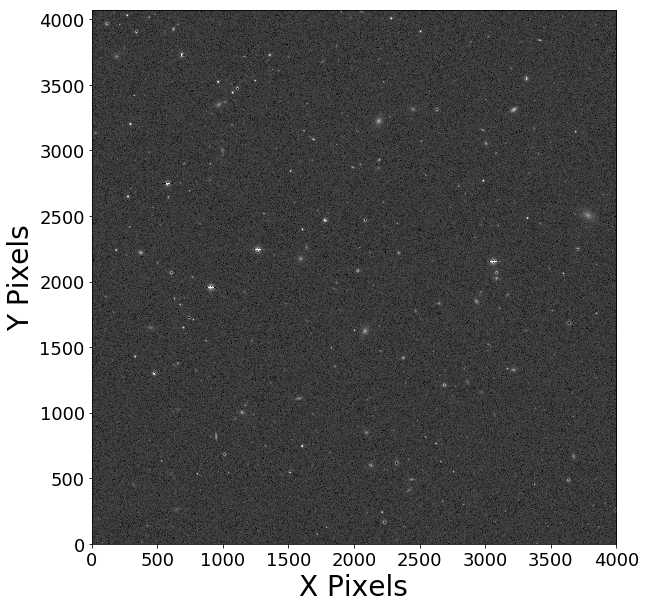

In [7]:
fig = plt.figure(figsize=(8,8))
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
# Since we are using matplotlib as a backend we can add labels using pyplot commands
plt.xlabel('X Pixels', size=28)
plt.ylabel('Y Pixels', size=28)
plt.xticks(size=18)
plt.yticks(size=18)

We've now loaded an image but need to translate the ra, dec coordinates of the truth catalog into pixel values in the image. To do this we will get the WCS information for the `calexp`.

In [8]:
wcs = calexp.getWcs()

Now we will pick a twinkles system to look at. We will use twinkles system 27 since it has a good separation between its images.

In [9]:
twinkles_sys = 27
test_images = twinkles_agn_truth.query('twinkles_system == %i' % twinkles_sys) 
test_images

,galid,ra,dec,mag,sed_name,z,twinkles_system,twinkles_img_num,lens_galids
130,21758535790620,52.919773,-27.427790,20.929559,agnSED/agn.spec.gz,1.54,27,0,2175853594
131,21758535791644,52.920295,-27.426956,19.309662,agnSED/agn.spec.gz,1.54,27,1,2175853594


In [10]:
test_lens = twinkles_lens_truth.query('galid == %i' % test_images['lens_galids'].iloc[0])
test_lens

,galid,ra,dec,mag,z,majorAxis,minorAxis,positionAngle
54,2175853594,52.919874,-27.427634,17.798418,0.188,0.000014,0.000012,0.629425


Now we use the WCS for the `calexp` and the ra, dec for our lensing galaxy and images to get pixel coordinates.

In [11]:
x_lens, y_lens = wcs.skyToPixel(SpherePoint(Angle(float(test_lens['ra']), degrees),
                                            Angle(float(test_lens['dec']), degrees)))
print(x_lens, y_lens)

2128.814015126872 599.9111778975384


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  if __name__ == '__main__':
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) SpherePoint. (Replaced by lsst.geom.SpherePoint (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app


In [12]:
x_image_1, y_image_1 = wcs.skyToPixel(SpherePoint(Angle(float(test_images['ra'].iloc[0]), degrees),
                                                  Angle(float(test_images['dec'].iloc[0]), degrees)))
x_image_2, y_image_2 = wcs.skyToPixel(SpherePoint(Angle(float(test_images['ra'].iloc[1]), degrees),
                                                  Angle(float(test_images['dec'].iloc[1]), degrees)))
print(x_image_1, y_image_1)
print(x_image_2, y_image_2)

2131.9112774649925 598.9686787766198
2115.4027293071094 603.6998615643508


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  if __name__ == '__main__':
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) SpherePoint. (Replaced by lsst.geom.SpherePoint (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lss

### Display a Twinkles System

Let's setup a bounding box to create a cutout of just this system.

In [13]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(x_lens-150, y_lens-150))
cutout = calexp[bbox]

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Call to deprecated function (or staticmethod) Box2I. (Replaced by lsst.geom.Box2I (will be removed before the release of v20.0))
  if __name__ == '__main__':
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) Point2I. (Replaced by lsst.geom.Point2I (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app


Here we display the system using `zoom` and `pan` to zoom in and center the image directly on our lens galaxy.

(array([540., 560., 580., 600., 620., 640., 660.]),
 <a list of 7 Text yticklabel objects>)

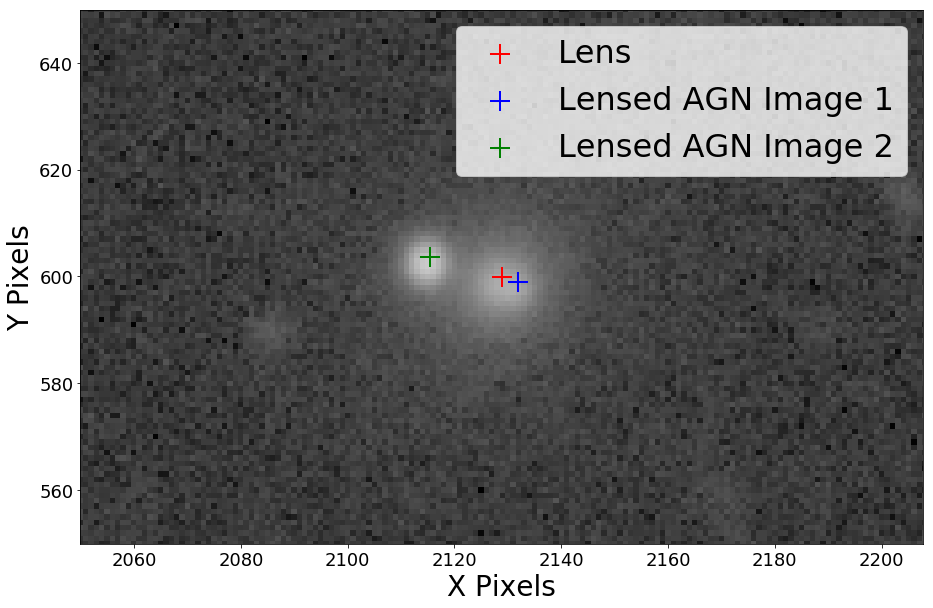

In [14]:
fig = plt.figure(figsize=(12,8))

display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
display1.zoom(80)
display1.pan(x_lens, y_lens)
plt.scatter(x_lens, y_lens, c='r', marker='+', label='Lens', s=400, lw=2)
plt.scatter(x_image_1, y_image_1, c='b', marker='+', label='Lensed AGN Image 1', s=400, lw=2)
plt.scatter(x_image_2, y_image_2, c='g', marker='+', label='Lensed AGN Image 2', s=400, lw=2)
plt.legend(fontsize=32)
plt.xlabel('X Pixels', size=28)
plt.ylabel('Y Pixels', size=28)
plt.xticks(size=18)
plt.yticks(size=18)

## Get Source Catalogs and match to Truth

Here we'll use the butler to get source catalogs for all the visits in the `r` band and match these source catalogs to our truth. First we use the butler to get the subset of r-band visits.

In [15]:
r_band_subset = butler.subset('src', filter='r')

Let's take the source catalog from the first visit and make the same plot as before but this time include all identified sources in the DM catalog.

In [16]:
src_cat = butler.get('src', dataId = r_band_subset.cache[0]).asAstropy().to_pandas()

In [17]:
src_pix = [wcs.skyToPixel(SpherePoint(Angle(float(src_cat['coord_ra'][idx])),
                                      Angle(float(src_cat['coord_dec'][idx]))))for idx in range(len(src_cat))]

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) Angle. (Replaced by lsst.geom.Angle (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: Call to deprecated function (or staticmethod) SpherePoint. (Replaced by lsst.geom.SpherePoint (will be removed before the release of v20.0))
  from ipykernel import kernelapp as app
/opt/lsst/software/stack/python/miniconda3-4.5

(array([540., 560., 580., 600., 620., 640., 660.]),
 <a list of 7 Text yticklabel objects>)

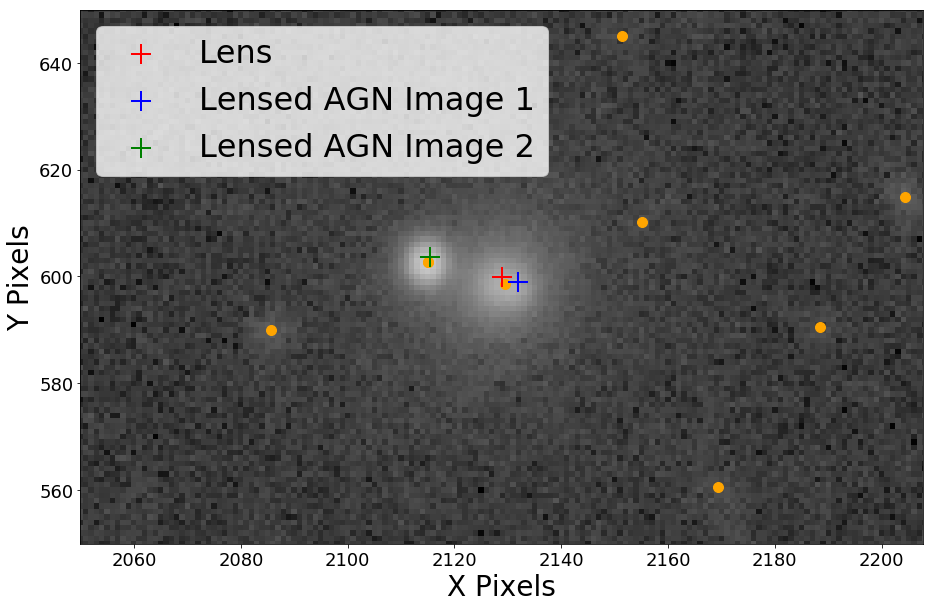

In [18]:
fig = plt.figure(figsize=(12,8))

display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale('asinh', 'zscale')
display1.mtv(calexp.image)
display1.zoom(80)
display1.pan(x_lens, y_lens)
plt.scatter(x_lens, y_lens, c='r', marker='+', label='Lens', s=400, lw=2, zorder=10)
plt.scatter(x_image_1, y_image_1, c='b', marker='+', label='Lensed AGN Image 1', s=400, lw=2, zorder=10)
plt.scatter(x_image_2, y_image_2, c='g', marker='+', label='Lensed AGN Image 2', s=400, lw=2, zorder=10)
for idx in range(len(src_pix)):
    src_loc = src_pix[idx]
    plt.scatter(src_loc[0], src_loc[1], c='orange', s=100, zorder=1)
plt.legend(fontsize=32)
plt.xlabel('X Pixels', size=28)
plt.ylabel('Y Pixels', size=28)
plt.xticks(size=18)
plt.yticks(size=18)

We see that the AGN image #2 is identified as its own source very close to the true position but that the lensing galaxy and AGN image #1 are blended together and identified as a single source in the output catalog. Let's make this easy on ourselves and focus on building a lightcurve for AGN image #2 below which should be well identified in all 10 r-band images available.

To do catalog matching we will use Astropy's `match_to_catalog_sky` method. This will require creating SkyCoord objects with the ra, dec coordinates of our truth catalog in the next cell and then in each visit doing the same with the source catalogs.

In [19]:
lens_coords = SkyCoord(test_lens['ra']*u.deg, test_lens['dec']*u.deg)
image_coords = SkyCoord(test_images['ra']*u.deg, test_images['dec']*u.deg)

Now we will loop through all the r-band visits and get three things from the butler:

1) Source catalogs: These will have all the sources in each visit. We will use this to match to our truth catalog and get fluxes.

2) Calexps: The processed images. We will need this to get the information necessary to convert the source catalog fluxes into magntiudes with a `photoCalib`. When we have a `photoCalib` object we can use `instFluxToMagnitude` to convert `base_PsfFlux_instFlux` values in the source catalog to magnitudes.

3) Calexp Metadata: The metadata will contain information from the FITS headers of the images and we will use this to get the MJD of each visit for our light curve.

Once we have all this information for each visit we use `match_to_catalog_sky` with our truth locations and identify the source catalog entry that is our AGN image.

In [20]:
image_mags = []
image_errs_high = []
image_errs_low = []
image_times = []

for dataId in r_band_subset.cache:
    
    # Get data products from Butler
    src_cat = butler.get('src', dataId = dataId).asAstropy().to_pandas()
    calexp = butler.get('calexp', dataId = dataId)
    metadata = butler.get('calexp_md', dataId=dataId)
    
    # Get image times from metadata
    image_times.append(metadata['MJD-OBS'])
    
    # Get PhotoCalib objet and calculate magnitudes
    calib = calexp.getPhotoCalib()
    src_mags = [calib.instFluxToMagnitude(flux) for flux in src_cat['base_PsfFlux_instFlux']]
    src_errs_high = [calib.instFluxToMagnitude(flux+flux_err) for flux, flux_err in zip(src_cat['base_PsfFlux_instFlux'],
                                                                                   src_cat['base_PsfFlux_instFluxErr'])]
    src_errs_low = [calib.instFluxToMagnitude(flux-flux_err) for flux, flux_err in zip(src_cat['base_PsfFlux_instFlux'],
                                                                                   src_cat['base_PsfFlux_instFluxErr'])]
    src_cat['r_mag'] = src_mags
    src_cat['r_err_high'] = src_errs_high
    src_cat['r_err_low'] = src_errs_low
    
    # Use Astropy to match catalogs and identify source that matches to AGN image we want
    visit_coords = SkyCoord(src_cat['coord_ra']*u.rad, src_cat['coord_dec']*u.rad)
    idx, sep2d, sep3d = image_coords.match_to_catalog_sky(visit_coords)
    
    # Use index 1 since we want the second of our two images. Save magnitude information for our light curve.
    image_mags.append(src_cat.iloc[idx[1]]['r_mag'])
    image_errs_high.append(src_cat.iloc[idx[1]]['r_err_high'] - src_cat.iloc[idx[1]]['r_mag'])
    image_errs_low.append(src_cat.iloc[idx[1]]['r_mag'] - src_cat.iloc[idx[1]]['r_err_low'])

Now we have all the information we need to plot the light curve below!

(array([18.87, 18.88, 18.89, 18.9 , 18.91, 18.92, 18.93, 18.94, 18.95,
        18.96, 18.97]), <a list of 11 Text yticklabel objects>)

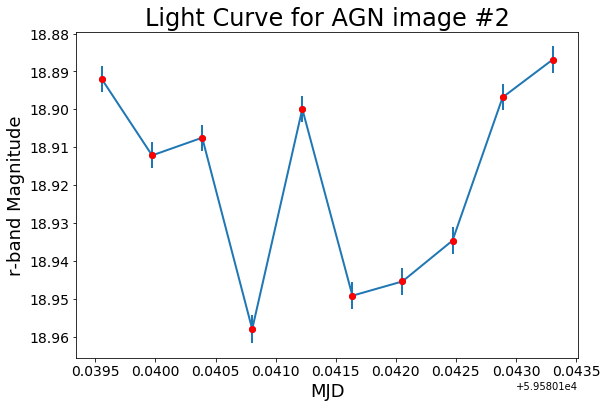

In [21]:
fig = plt.figure(figsize=(9, 6))
plt.errorbar(image_times, image_mags, yerr=[image_errs_high, image_errs_low], marker='o', lw=2)
plt.scatter(image_times, image_mags, c='r', zorder=10)
plt.gca().invert_yaxis()
plt.xlabel('MJD', size=18)
plt.ylabel('r-band Magnitude', size=18)
plt.title('Light Curve for AGN image #2', size=24)
plt.xticks(size=14)
plt.yticks(size=14)